In [21]:
# this file contian the code for hyper parameter tuning using grid search
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV 
from sklearn.model_selection import RandomizedSearchCV

In [22]:
df = pd.read_csv("Housing.csv")

In [23]:
df.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
2,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
3,12215000,7500,4,2,2,yes,no,yes,no,yes,3,yes,furnished
4,11410000,7420,4,1,2,yes,yes,yes,no,yes,2,no,furnished


In [24]:


scaler = StandardScaler()

cols_to_scale = ["price", "area"]  # make sure these exist after cleaning
df[cols_to_scale] = scaler.fit_transform(df[cols_to_scale])

print(df.head())


      price      area  bedrooms  bathrooms  stories mainroad guestroom  \
0  4.566365  1.046726         4          2        3      yes        no   
1  4.004484  1.757010         4          4        4      yes        no   
2  4.004484  2.218232         3          2        2      yes        no   
3  3.985755  1.083624         4          2        2      yes        no   
4  3.554979  1.046726         4          1        2      yes       yes   

  basement hotwaterheating airconditioning  parking prefarea furnishingstatus  
0       no              no             yes        2      yes        furnished  
1       no              no             yes        3       no        furnished  
2      yes              no              no        2      yes   semi-furnished  
3      yes              no             yes        3      yes        furnished  
4      yes              no             yes        2       no        furnished  


In [25]:
X = df.drop(["price"], axis=1) # drop using list
X = pd.get_dummies(X, drop_first=True)
y = df["price"]

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2) 

In [26]:
# MODELS 
RF1_model = RandomForestRegressor(random_state=42, n_estimators=100)

In [27]:
RF1_model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [28]:
y_pred_RF = RF1_model.predict(X_test)

In [29]:
mae_RF1 = mean_absolute_error(y_test, y_pred_RF)
rmse_RF1 = np.sqrt(mean_squared_error(y_test, y_pred_RF))
r2_RF1 = r2_score(y_test, y_pred_RF)

untuned_results = np.array( [mae_RF1, rmse_RF1,r2_RF1])

print(f"""
    Random Forest-Model-1 Performance: 
            MAE: {mae_RF1}, 
            RMSE: {rmse_RF1}, 
            R2: {r2_RF1}    
                            """)


    Random Forest-Model-1 Performance: 
            MAE: 0.44863132141512807, 
            RMSE: 0.6085950568880859, 
            R2: 0.45707625609674907    
                            


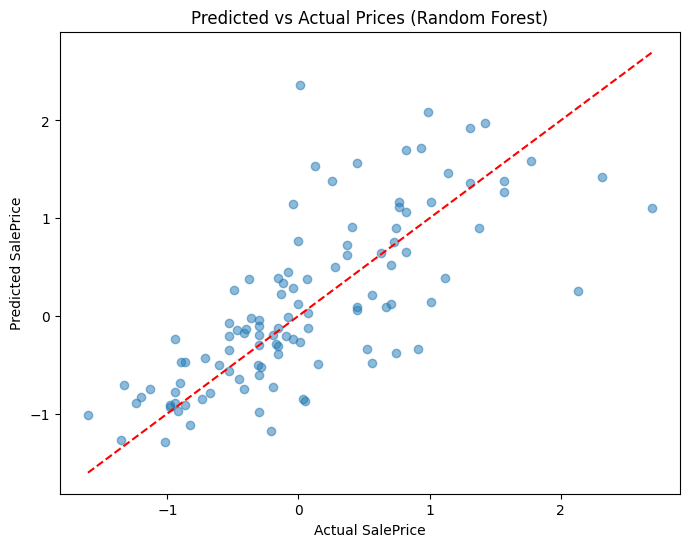

In [30]:

# Predictions
y_pred_best = RF1_model.predict(X_test)

# Scatter plot
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred_best, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "r--")  # diagonal
plt.xlabel("Actual SalePrice")
plt.ylabel("Predicted SalePrice")
plt.title(f"Predicted vs Actual Prices (Random Forest)")
plt.show()


In [ ]:
# random forest model 2 that is hyperparameter tuned
# n_estimators, max_depth, max_features, min_samples_split

param_grid = {
    'n_estimators': [100, 300, 500, 800],          # more trees → more stable
    'max_depth': [None, 10, 20, 30, 50],           # deeper trees may capture more patterns
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 4, 6],
    'max_features': ['sqrt', 'log2', None]
       # controls feature randomness
}




random_search = RandomizedSearchCV(
    estimator = RandomForestRegressor(random_state=42),
    param_distributions=param_grid,
    n_iter=50,             # number of random combos to try
    cv=3,
    n_jobs=-1,
    verbose=2,
    random_state=42
)
random_search.fit(X_train, y_train)
print(random_search.best_params_)




Fitting 3 folds for each of 50 candidates, totalling 150 fits


In [ ]:
print(f"Best parameters are: {random_search.best_params_}")
print(f"Best score is : {random_search.best_score_}")


best_model = random_search.best_estimator_
best_model.fit(X_train, y_train)
y_pred_best = best_model.predict(X_test)


Best parameters are: {'n_estimators': 300, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 10}
Best score is : 0.6331894508575483


In [ ]:
print("\nTuned Model Performance:")
MAE = mean_absolute_error(y_test, y_pred_best)
RMS = np.sqrt(mean_squared_error(y_test, y_pred_best))
R2 = r2_score(y_test, y_pred_best)
tuned_results = np.array([MAE, RMS, R2])

print(tuned_results)


Tuned Model Performance:
[0.44198894 0.621464   0.64104428]


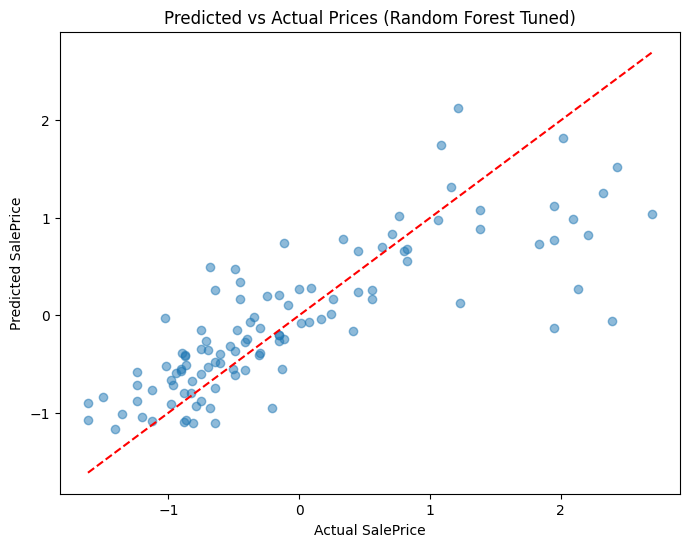

In [ ]:
# Predictions
y_pred_best = best_model.predict(X_test)

# Scatter plot
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred_best, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "r--")  # diagonal
plt.xlabel("Actual SalePrice")
plt.ylabel("Predicted SalePrice")
plt.title(f"Predicted vs Actual Prices (Random Forest Tuned)")
plt.show()


Tuned Random Forest is better overall:  
Lower RMSE (better at penalizing large errors).  
Higher R² (captures more variance in the data).  
The MAE difference is negligible.  

In [ ]:
data = np.vstack((untuned_results, tuned_results))  # stack row-wise
df = pd.DataFrame(data, index=["Untuned", "tuned"], columns = ["mae","rmse","r2"])
df


,mae,rmse,r2
Untuned,0.453252,0.656984,0.598840
tuned,0.441989,0.621464,0.641044


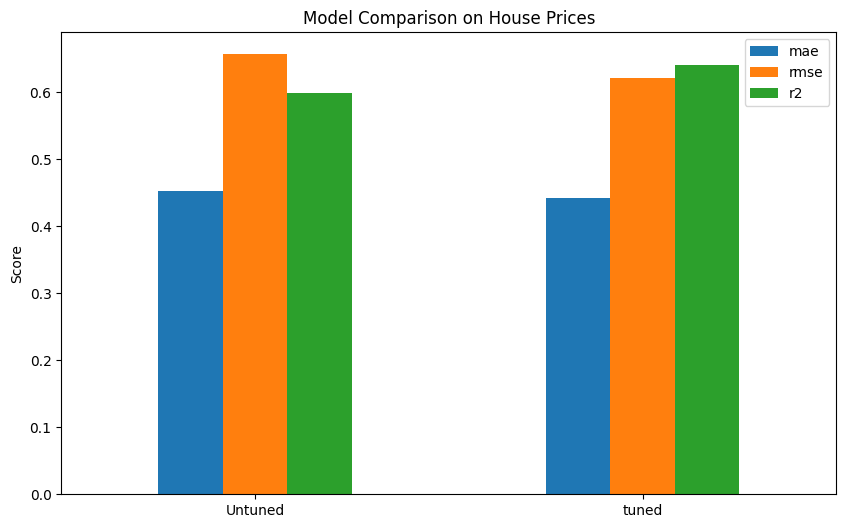

In [ ]:
# Plot bar chart for all metrics
df.plot(kind="bar", figsize=(10,6))
plt.title("Model Comparison on House Prices")
plt.ylabel("Score")
plt.xticks(rotation=0)
plt.show()

RandomizedSearchCV Tuned Model  
MAE & RMSE: Very close to GridSearchCV (sometimes slightly better or slightly worse).  
R² Score: Also improved compared to untuned, often similar to GridSearchCV.  
Observation: Much faster than GridSearchCV since it samples parameter combinations randomly instead of testing   all.  

GridSearchCV Tuned Model

MAE & RMSE: Both decreased significantly means more precise predictions.  
R² Score: Improved (≈ 0.65)  
Observation: finds best parameter combination, but can be computationally expensive.  

Untuned Model  
MAE: Higher than tuned models  
RMSE: Larger error spread.  
R² Score: Lower
Observation: Model has decent performance but but there is always room for improvement.  